In [1]:

import numpy as np
import scipy
import glob
import math as m
from qiskit import *
from qiskit.quantum_info import *
from qiskit.providers.aer.noise import *
from qiskit.providers.aer.utils import insert_noise
from qiskit.visualization import plot_histogram
sys.path.append("..")
from json_tools import *

"""
The goal of this script is to verify that the circuits generated by the
Stinespring algorithm indeed do produce a valid QPD.
For that we consider a circuit with some random (non-noisy) single-qubit
unitaries and a noisy CNOT that we correct with the quasiprobability method.
"""

# noise_model = NoiseModel.from_dict(json_from_file("2020_04_08.json"))
# noise_model.add_quantum_error(noise_model._local_quantum_errors['cx']['2,3'], 'cx', [0,2])
# noise_model.add_quantum_error(noise_model._local_quantum_errors['cx']['3,2'], 'cx', [2,0])

# Example error probabilities
# p_meas = 0.01
p_gate1 = 0.0075
p_depolarizing=0.0075
p_phase=0.0075

# QuantumError objects
# error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_dep = depolarizing_error(p_depolarizing, 1)
error_dep2 = error_dep.tensor(error_dep)
error_phase = pauli_error([('Z', p_phase), ('I', 1 - p_phase)])
error_phase2 = error_phase.tensor(error_phase)

# Add errors to noise model
noise_model = NoiseModel()
# noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])
noise_model.add_all_qubit_quantum_error(error_dep2, ["cx"])
noise_model.add_all_qubit_quantum_error(error_phase2, ["cx"])
noise_model.add_all_qubit_quantum_error(error_dep, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_phase, ["u1", "u2", "u3"])

# load quasiprobability coefficients generated by Stinespring algorithm
coeffs = np.load("data_0.0075/final_cnot.npz")["arr_2"]
noise_choi = np.load("data_0.0075/final_cnot.npz")["arr_1"]

# load circuits generated by Strinespring algorithm
def read_file(path):
    with open(path, 'r') as f:
        return f.read()
num_files = len(glob.glob("data_0.0075/*.qasm"))
qasm_circuits = [read_file("data_0.0075/final_cnot_sim_circ"+str(f)+".qasm") for f in range(num_files)]
circuits = [QuantumCircuit.from_qasm_str(s) for s in qasm_circuits]

In [2]:
qc = QuantumCircuit(2)
qc.cx(0,1)
target_unitary = Operator(qc).data
target_choi = Choi(qc).data
#print(coeffs)
sum=0
print(coeffs[0])
for i in range(len(coeffs)):
    sum=sum+abs(coeffs[i])
print(coeffs)

1.0441332903657476
[ 1.04413329e+00  2.37791251e-05 -2.54882582e-02 -2.84852383e-02
 -2.88899139e-03  6.15067159e-03  8.31775879e-03 -5.93093355e-03
 -1.19245589e-02  2.44882644e-03  1.11730688e-02  6.60578161e-03
  1.19045720e-03  7.11438334e-04  2.04582392e-04 -7.85446958e-05
 -6.80499754e-06 -2.92162985e-05 -2.85170848e-03 -1.51359341e-03
 -1.00808010e-03 -1.56259376e-04  2.22781781e-04 -9.41063608e-05
 -5.14544135e-05 -1.01055356e-04  6.10648918e-04  4.10167966e-04
  2.75508373e-04  3.21629465e-04 -9.27776949e-05  2.86968567e-05
  6.30347254e-05  7.09637338e-05 -7.09213359e-04 -4.95230983e-04
 -4.56451915e-04 -5.73683364e-04 -1.16615363e-05 -4.07460039e-05
 -1.95741634e-05  1.84751474e-05  5.74956387e-05  5.76635312e-05
  5.10158670e-05  4.04570340e-05  8.23978183e-06  2.26353930e-05
  2.32578844e-05  1.12174600e-05 -7.58261481e-05 -3.78497981e-05
 -4.83431103e-05 -2.76011437e-05 -1.73171794e-06 -1.44150924e-05
 -2.06832331e-05 -1.32278868e-05  4.29721745e-06  3.24048506e-06
  4.12

In [3]:
#verify choi matrix
noisy=0
for i in range(len(coeffs)):
    noisy=noisy+coeffs[i]*noise_choi[i]
print(np.square(np.subtract(noisy, target_choi)).mean())


(3.5744563527855767e-19+0j)


In [4]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.circuit.library.standard_gates.equivalence_library import StandardEquivalenceLibrary
from qiskit.circuit.library import standard_gates
import random

In [5]:
def mycx_sample(num,shots):
    idxlist = range(len(circuits))
    subqcidxList={}
    subqccoeffs={}
    for i in range(shots):
        result1=random.choices(idxlist,weights=abs(coeffs),k=num)
        strr=''
        for j in range(num):
            strr=strr+' '+str(result1[j])
        if strr in subqcidxList.keys():
            subqcidxList[strr]+=1 
        else:
            subqcidxList[strr]=1
            result2=1
            for j in range(num):
                result2 = result2*coeffs[result1[j]]
            #print(result1[0],result2)
            if result2>0: 
                subqccoeffs[strr]=1
            else:
                subqccoeffs[strr]=-1
    #print(subqcidxList)
    #print(subqccoeffs)
    return subqcidxList, subqccoeffs

In [6]:
print(len(circuits))
print(len(coeffs))

106
106


In [7]:
# mycx_sample(2,100000)

In [8]:
def append_cnot(qc,subqc,place):
    if subqc.num_qubits == 2:
        qctot = QuantumCircuit(2)
        qctot += subqc
        qc_noisy = insert_noise(qctot, noise_model)
        # qctot.to_gate()
        qc.append(qc_noisy, place[:2])
    elif subqc.num_qubits == 3:
        qctot = QuantumCircuit(3)
        qctot.reset(2)       
        qctot += subqc
        qc_noisy = insert_noise(qctot, noise_model)
        # qctot.to_gate()
        qc.append(qc_noisy, place)
    else: raise

In [9]:
# import math as m
# gate_set,coeff_set=mycx_sample(1,100000)
# for set in gate_set.keys():
#     cirs=set.split()
#     print(set)

{}
start


C:\Users\jack_\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  # This is added back by InteractiveShellApp.init_path()
C:\Users\jack_\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  if sys.path[0] == '':
C:\U

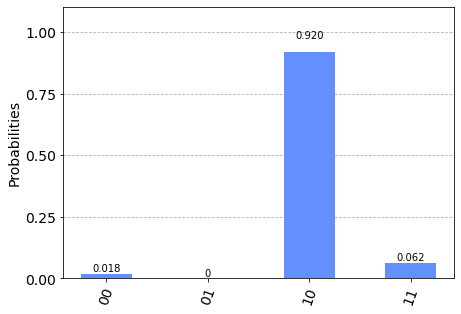

In [10]:
gate_set,coeff_set=mycx_sample(11,20000)
backend = Aer.get_backend('qasm_simulator')
totalcount=dict()
print(totalcount)
print('start')
sum=0
for set in gate_set.keys():
    cirs=set.split()

    qc=QuantumCircuit(5,2)
    qc.u3(m.pi, 0, m.pi, 0)
    qc.u3(m.pi, 0, m.pi, 1)
    qc.barrier()
    qc.u3(m.pi/2, 0, m.pi, 3)
    append_cnot(qc,circuits[int(cirs[0])],[1,3,4])
    qc.u3(0, 0, -m.pi/4, 3)
    append_cnot(qc,circuits[int(cirs[1])],[0,3,4])
    qc.u3(0, 0, m.pi/4, 3)
    append_cnot(qc,circuits[int(cirs[2])],[1,3,4])
    qc.u3(0, 0, m.pi/4, 1)
    qc.u3(0, 0, -m.pi/4, 3)
    append_cnot(qc,circuits[int(cirs[3])],[0,3,4])
    append_cnot(qc,circuits[int(cirs[4])],[0,1,4])
    qc.u3(0, 0, 9*m.pi/4, 3)
    qc.u3(0, 0, m.pi/4, 0)
    qc.u3(0, 0, -m.pi/4, 1)
    append_cnot(qc,circuits[int(cirs[5])],[2,3,4])
    qc.u3(0, 0, -m.pi/4, 3)
    append_cnot(qc,circuits[int(cirs[6])],[1,3,4])
    qc.u3(0, 0, m.pi/4, 3)
    append_cnot(qc,circuits[int(cirs[7])],[2,3,4])
    qc.u3(0, 0, m.pi/4, 2)
    qc.u3(0, 0, -m.pi/4, 3)
    append_cnot(qc,circuits[int(cirs[8])],[1,3,4])
    append_cnot(qc,circuits[int(cirs[9])],[1,2,4])
    qc.u3(m.pi/2, 0, 5*m.pi/4, 3)
    qc.u3(0, 0, m.pi/4, 1)
    qc.u3(0, 0, -m.pi/4, 2)
    append_cnot(qc,circuits[int(cirs[10])],[0,1,4])
    qc.barrier()
    qc.measure([2,3],[0,1])

    qc_noisy = insert_noise(qc, noise_model)
    job = execute(qc_noisy, backend, shots=gate_set[set])
    counts = job.result().get_counts(qc_noisy)
    #print('result of',set,':',counts)
    #print('coeff:',coeff_set[set])
    #print('before addition:',totalcount)
    for data in counts:
        if data in totalcount.keys():
            if coeff_set[set] == 1:
                totalcount[data] += counts[data]
            elif coeff_set[set] == -1:
                totalcount[data] -= counts[data]
        else:
            if coeff_set[set] == 1:
                totalcount[data] = counts[data]
            elif coeff_set[set] == -1:
                totalcount[data] = -counts[data]

    #print('after addition:',totalcount)
    #print('next')
for key, value in totalcount.items():
    if value<0:
        totalcount[key] = 0
plot_histogram(totalcount)
    

In [11]:
#print(gate_set)

C:\Users\jack_\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  
C:\Users\jack_\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\

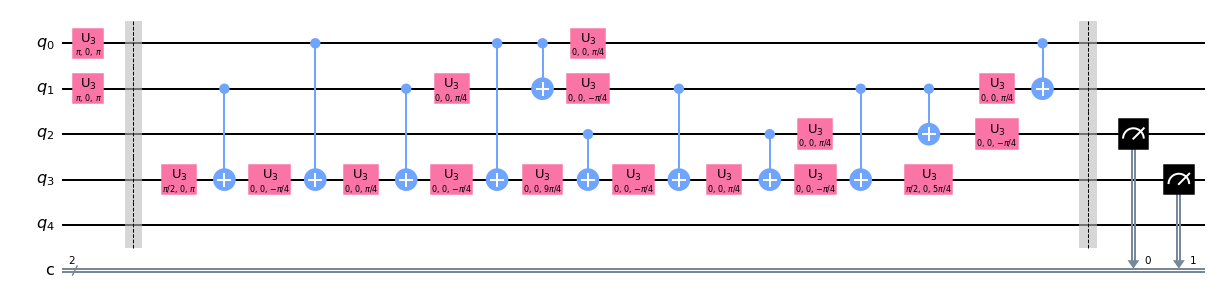

In [12]:
qc=QuantumCircuit(5,2)
qc.u3(m.pi, 0, m.pi, 0)
qc.u3(m.pi, 0, m.pi, 1)
qc.barrier()
qc.u3(m.pi/2, 0, m.pi, 3)
qc.cnot(1,3)
# append_cnot(qc,circuits[int(cirs[0])],[1,3,4])
qc.u3(0, 0, -m.pi/4, 3)
qc.cnot(0,3)
# append_cnot(qc,circuits[int(cirs[1])],[0,3,4])
qc.u3(0, 0, m.pi/4, 3)
qc.cnot(1,3)
# append_cnot(qc,circuits[int(cirs[2])],[1,3,4])
qc.u3(0, 0, m.pi/4, 1)
qc.u3(0, 0, -m.pi/4, 3)
qc.cnot(0,3)
# append_cnot(qc,circuits[int(cirs[3])],[0,3,4])
qc.cnot(0,1)
# append_cnot(qc,circuits[int(cirs[4])],[0,1,4])
qc.u3(0, 0, 9*m.pi/4, 3)
qc.u3(0, 0, m.pi/4, 0)
qc.u3(0, 0, -m.pi/4, 1)
qc.cnot(2,3)
# append_cnot(qc,circuits[int(cirs[5])],[2,3,4])
qc.u3(0, 0, -m.pi/4, 3)
qc.cnot(1,3)
# append_cnot(qc,circuits[int(cirs[6])],[1,3,4])
qc.u3(0, 0, m.pi/4, 3)
qc.cnot(2,3)
# append_cnot(qc,circuits[int(cirs[7])],[2,3,4])
qc.u3(0, 0, m.pi/4, 2)
qc.u3(0, 0, -m.pi/4, 3)
qc.cnot(1,3)
# append_cnot(qc,circuits[int(cirs[8])],[1,3,4])
qc.cnot(1,2)
# append_cnot(qc,circuits[int(cirs[9])],[1,2,4])
qc.u3(m.pi/2, 0, 5*m.pi/4, 3)
qc.u3(0, 0, m.pi/4, 1)
qc.u3(0, 0, -m.pi/4, 2)
qc.cnot(0,1)
# append_cnot(qc,circuits[int(cirs[10])],[0,1,4])
qc.barrier()
qc.measure([2,3],[0,1])

qc.draw(output='mpl', fold=-1)

{'10': 7081, '01': 623, '00': 944, '11': 1352}


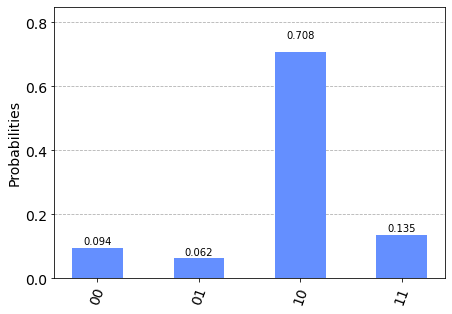

In [13]:
backend = Aer.get_backend('qasm_simulator')
qc_noisy = insert_noise(qc, noise_model)
job = execute(qc_noisy, backend, shots=10000)
counts = job.result().get_counts(qc_noisy)

print(counts)
plot_histogram(counts)

In [14]:
# backend = Aer.get_backend('qasm_simulator')
# def get_probab(qc):
#     qc.measure([0,1], [0,1])
#     shots = 100000 # make this higher to increase accuracy!
#     job = execute(qc, backend, shots=shots)
#     counts = job.result().get_counts(qc)
#     return counts

In [15]:
# # run circuits of different quasiprobability branches
# U = random_unitary(2, seed=1234) # 1237
# probabs = list()
# totalcount={}
# counter=0
# for qc in circuits:
#     qc_noisy = insert_noise(qc, noise_model)
#     if qc.num_qubits == 2:
#         qctot = QuantumCircuit(2, 2)
#         qctot.x(0)
#     elif qc.num_qubits == 3:
#         qctot = QuantumCircuit(3, 2)
#         qctot.x(0)
#     else: raise
#     qctot += qc_noisy
#     counts=get_probab(qctot)
#     for data in counts:
#         if data in totalcount.keys():
#             totalcount[data]+=counts[data]*coeffs[counter]
#         else:
#             totalcount[data]=counts[data]*coeffs[counter]
#     counter+=1

# # check
# print(totalcount)